In [1]:
#Packages
#! python3 -m pip install requests
#! python3 -m pip install json
#! python3 -m pip install matplotib
#! python3 -m pip install time
#! python3 -m pip install numpy
#! python3 -m pip install yfinance
#! python3 -m pip install pandas
#! python3 -m pip install torch
#! python3 -m pip install sklearn
#! python3 -m pip install scipy

In [33]:
#Packages
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import yfinance as yf
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import io
import time
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm

In [3]:
class Torch_CNN(nn.Module):
    def __init__(self, embed, num_pred):
        super(Torch_CNN, self).__init__()
        self.conv1 = nn.Conv2d(embed, 32, kernel_size=3, padding=1) #Expansion graduelle
        self.pool1 = nn.MaxPool2d(2)
        self.bn_pool1 = nn.BatchNorm2d(32) # meilleur performance a l'entrainement

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.bn_pool2 = nn.BatchNorm2d(64) # meilleur performance a l'entrainement

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.bn_pool3 = nn.BatchNorm2d(128) # meilleur performance a l'entrainement

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, num_pred) # Matrice 128 x pred

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.conv1(x)) #Leaky relu
        x = self.pool1(x)
        x = self.bn_pool1(x)

        x = torch.nn.functional.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn_pool2(x)

        x = torch.nn.functional.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn_pool3(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Test FNN fusion
class Torch_FFN(nn.Module):
    def __init__(self, embed, hidden, num_pred):
        super(Torch_FFN, self).__init__()
        self.norm = nn.LayerNorm(embed)
        self.fc1 = nn.Linear(embed, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, num_pred) # hidde x num de prediction
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        x = self.norm(x)
        x = self.dropout(torch.nn.functional.leaky_relu(self.fc1(x)))
        x = self.dropout(torch.nn.functional.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


# Corrected Ensemble model
class Torch_Ens(nn.Module):
    def __init__(self, embed_img, ts_input_dim, hidden_dim, num_pred):
        super().__init__()
        self.cnn = Torch_CNN(embed_img, ts_input_dim) # sortie meme taille que input ts
        self.fnn = Torch_FFN(ts_input_dim * 2, hidden_dim, hidden_dim) # 2 fois ts pour que le FNN est le meme nombre de feature par modalité
        self.regression_head = nn.Linear(hidden_dim, num_pred)
        self.classification_head = nn.Linear(hidden_dim, 2) # 2 options 0 ou 1

    def forward(self, x_img, x_ts):
        x_img_out = self.cnn(x_img)
        x = torch.cat([x_img_out, x_ts], dim=1)
        x = self.fnn(x)
        price_pred = self.regression_head(x)
        direction_logits = self.classification_head(x)
        return price_pred, direction_logits



In [4]:
#Test
## El Model
model = Torch_Ens(
    embed_img=3, #Red / Green / Blue
    ts_input_dim=10,
    hidden_dim=256,
    num_pred=1
)

batch_size = 2
x_img = torch.randn(batch_size, 3, 192, 192)
x_ts = torch.randn(batch_size, 10)

print(f"Image shape: {x_img.shape}")
print(f"Time series shape: {x_ts.shape}")

output = model(x_img, x_ts)
print(f"out shape: {output}")


with torch.no_grad():
    cnn_features = model.cnn(x_img)
    print(f"CNN feature std: {cnn_features.std()}")
    print(f"CNN feature mean: {cnn_features.mean()}")

Image shape: torch.Size([2, 3, 192, 192])
Time series shape: torch.Size([2, 10])
out shape: (tensor([[-0.0298],
        [-0.0096]], grad_fn=<AddmmBackward0>), tensor([[ 0.0798, -0.0370],
        [ 0.1157,  0.0153]], grad_fn=<AddmmBackward0>))
CNN feature std: 0.04106758534908295
CNN feature mean: -0.0022449265234172344


In [5]:
start_date = "2016-02-06"
end_date = "2026-02-06"
Tickers = ["ZC=F", "ZW=F", "ZM=F", "GF=F", "LE=F"]

df_list = []

for ticker_symbol in Tickers:
    data = yf.download(ticker_symbol, start_date, progress=False, auto_adjust=False, interval="1d")
    adj_close_series = data['Adj Close'].squeeze().dropna()
    ticker_df = adj_close_series.to_frame(name=ticker_symbol)
    df_list.append(ticker_df)

df_close = pd.concat(df_list, axis=1)
df_close = df_close.dropna()

column_names_map = {
    "ZW=F": "Wheat",
    "ZM=F": "Soy",
    "GF=F": "Cow_food",
    "LE=F": "Cows",
    "^IRX": "UST",
    "NG=F": "Gaz"
}

df_close.rename(columns=column_names_map, inplace=True)

df_close.head()

,ZC=F,Wheat,Soy,Cow_food,Cows
Date,,,,,
2016-03-09,359.00,463.75,269.600006,159.050003,136.774994
2016-03-10,362.50,471.50,270.200012,161.550003,138.300003
2016-03-11,366.00,469.75,272.000000,162.399994,139.800003
2016-03-14,366.75,471.50,268.100006,162.050003,139.300003
2016-03-15,368.50,477.25,268.200012,163.975006,140.725006


In [6]:

latitude = 39.0997
longitude = -94.5786 #Chicago

url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "daily": ["temperature_2m_mean","rain_sum"],
    "timezone": "America/Chicago",
    "models": "best_match"
}


response = requests.get(url, params=params, timeout=30)

if response.status_code == 200:
    data = response.json()

    if 'daily' in data and 'time' in data['daily']:
        # Créer le DataFrame
        dates = pd.to_datetime(data['daily']['time'])
        temperatures = data['daily']['temperature_2m_mean']
        precipitation = data['daily']['rain_sum']

        df_temp = pd.DataFrame({
            'date': dates,
            'temperature': temperatures,
            'precipitation': precipitation
        })

df_temp = df_temp.set_index('date')
df_close = df_close.join(df_temp, how='inner', rsuffix='_weather').dropna() #Intersection

df_close.head()

,ZC=F,Wheat,Soy,Cow_food,Cows,temperature,precipitation
2016-03-09,359.00,463.75,269.600006,159.050003,136.774994,12.3,1.4
2016-03-10,362.50,471.50,270.200012,161.550003,138.300003,11.9,0.0
2016-03-11,366.00,469.75,272.000000,162.399994,139.800003,11.9,0.0
2016-03-14,366.75,471.50,268.100006,162.050003,139.300003,14.8,1.6
2016-03-15,368.50,477.25,268.200012,163.975006,140.725006,14.5,3.3


In [7]:

corr = df_close.corr()
mean = df_close.mean()
std = df_close.std()
median = df_close.median()
print(corr)

print(f"STD \n {std}")
print(f"MEAN \n {mean}")
print(f"MEDIAN \n {median}")

                   ZC=F     Wheat       Soy  Cow_food      Cows  temperature  \
ZC=F           1.000000  0.899244  0.770243  0.096500  0.204221    -0.048548   
Wheat          0.899244  1.000000  0.681450  0.040086  0.122972    -0.027251   
Soy            0.770243  0.681450  1.000000 -0.111811 -0.002941    -0.070606   
Cow_food       0.096500  0.040086 -0.111811  1.000000  0.974544     0.046086   
Cows           0.204221  0.122972 -0.002941  0.974544  1.000000    -0.048043   
temperature   -0.048548 -0.027251 -0.070606  0.046086 -0.048043     1.000000   
precipitation  0.010985  0.019903 -0.027747 -0.020752 -0.035353     0.160489   

               precipitation  
ZC=F                0.010985  
Wheat               0.019903  
Soy                -0.027747  
Cow_food           -0.020752  
Cows               -0.035353  
temperature         0.160489  
precipitation       1.000000  
STD 
 ZC=F             120.631365
Wheat            147.942709
Soy               59.130872
Cow_food          62.

In [8]:

params = {
"SERVICE": "WMS",
"REQUEST": "GetMap",
"VERSION": "1.3.0",
"LAYERS": "MODIS_Terra_NDVI_8Day", #Indices de vegetation
"CRS": "EPSG:4326",
"BBOX": "40,-97,44,-87",
"WIDTH": 128, # On baisse la résolution
"HEIGHT": 128,
"FORMAT": "image/png",
"TIME": "01-01-2020",
"TRANSPARENT": "FALSE"""
}

def Get_image_data(df):
    dates =  df.index.strftime('%Y-%m-%d').tolist() #On change le format


    images_dict={}
    for i, date in enumerate(dates):
        if i > 0:
            time.sleep(0.05)  #On est gentil avec l'API de la Nasa
        params['TIME'] = date
        print(f"{params['TIME']}")
        try:
            API_endpoint = "https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi"
            response = requests.get(API_endpoint, params=params, timeout=30)

            if response.status_code == 200:  # Success
                if response.content.startswith(b'\x89PNG'):
                    img = mpimg.imread(io.BytesIO(response.content))
                    images_dict[date] = img
                else:
                    print(f"Response not PNG for {date}")
                    print(response.text[:200])

            else:
                print(f"Error {response.status_code} for {date}")

        except Exception as e:
            print(f"Erreur pour {date}: {str(e)}")
    return images_dict

images_dict = Get_image_data(df_close)

2016-03-09
2016-03-10
2016-03-11
2016-03-14
2016-03-15
2016-03-16
2016-03-17
2016-03-18
2016-03-21
2016-03-22
2016-03-23
2016-03-24
2016-04-01
2016-04-04
2016-04-05
2016-04-06
2016-04-07
2016-04-08
2016-04-11
2016-04-12
2016-04-13
2016-04-14
2016-04-15
2016-04-18
2016-04-19
2016-04-20
2016-04-21
2016-04-22
2016-04-25
2016-04-26
2016-04-27
2016-04-28
2016-04-29
2016-05-02
2016-05-03
2016-05-04
2016-05-05
2016-05-06
2016-05-09
2016-05-10
2016-05-11
2016-05-12
2016-05-13
2016-05-16
2016-05-17
2016-05-18
2016-05-19
2016-05-20
2016-05-23
2016-05-24
2016-05-25
2016-05-26
2016-05-27
2016-05-31
2016-06-01
2016-06-02
2016-06-03
2016-06-06
2016-06-07
2016-06-08
2016-06-09
2016-06-10
2016-06-13
2016-06-14
2016-06-15
2016-06-16
2016-06-17
2016-06-20
2016-06-21
2016-06-22
2016-06-23
2016-06-24
2016-06-27
2016-06-28
2016-06-29
2016-06-30
2016-07-01
2016-07-05
2016-07-06
2016-07-07
2016-07-08
2016-07-11
2016-07-12
2016-07-13
2016-07-14
2016-07-15
2016-07-18
2016-07-19
2016-07-20
2016-07-21
2016-07-22

In [9]:
# Sauvegarde des séries
np.savez_compressed('images.npz', **{date: img for date, img in images_dict.items()})
df_close.to_csv('prices.csv')

In [10]:
def compute_direction_labels(value, threshold=0.0):
    labels = torch.ones_like(value, dtype=torch.long) #On met tt les labels en 1 puis on le passe en 0 si c'est une baisse
    labels[value < -threshold] = 0

    return labels

In [11]:
## On crée un dataset
images_npz = np.load('images.npz', mmap_mode = 'r')
images_dict = {date: images_npz[date] for date in images_npz.files}
df_close = pd.read_csv('prices.csv', index_col=0, parse_dates=True)

del images_npz  # LA MEMOIRE

class full_dataset(Dataset):
    def __init__(self, images_dict, df, target_col='ZC=F'):
        self.images_dict = images_dict
        self.df = df
        self.target_col = target_col

        self.valid_indices = []
        dates = df.index.strftime('%Y-%m-%d').tolist()

        for i in range(len(dates) - 1):
            if dates[i] in images_dict:  # Check que on a une image a cette data
                self.valid_indices.append(i)

        self.ts_min = self.df.min(axis=0).values
        self.ts_max = self.df.max(axis=0).values
        self.target_min = self.df[self.target_col].values.min()
        self.target_max = self.df[self.target_col].values.max()
        self.image_min = min(img.min() for img in images_dict.values())
        self.image_max = max(img.max() for img in images_dict.values())

    def __len__(self):
        return len(self.valid_indices) - 20 #les dernieres valeurs na pas de target

    def __getitem__(self, idx):
        df_idx = self.valid_indices[idx]
        date = self.df.index[df_idx].strftime('%Y-%m-%d')
        next_date = self.df.index[df_idx + 20]


        img = self.images_dict[date]

        if img.ndim == 3 and img.shape[2] == 4: #Formatv torch si probleme
            img = img[:, :, :3]

        img = img.transpose(2, 0, 1)

        ts = self.df.iloc[df_idx].values
        target = self.df.loc[next_date, self.target_col]
        change = target - self.df.iloc[df_idx][self.target_col]

        direction_labels = compute_direction_labels(torch.tensor(change, dtype=torch.float32), threshold=0)

        # Norm & Tensor
        ts_tensor = (ts - self.ts_min) / (self.ts_max - self.ts_min)
        target = (target - self.target_min) / (self.target_max - self.target_min)
        img = (img - self.image_min) / (self.image_max - self.image_min)
        target_tensor = torch.tensor(target, dtype=torch.float32)
        image_tensor = torch.from_numpy(img.copy()).float()
        ts_tensor = torch.tensor(ts_tensor.copy()).float()

        return image_tensor, ts_tensor, target_tensor, direction_labels


In [ ]:
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e #Pas de shift pour numpy dcp helper

## Training setup
model = Torch_Ens(
    embed_img=3,
    ts_input_dim=7,
    hidden_dim=256,
    num_pred=1
)

optimizer = torch.optim.Adam(lr=1e-3, weight_decay=1e-3, params=model.parameters())
regression_criterion = nn.MSELoss()

# Poid de la classification
alpha = 0.05
split_idx = int(0.8 * len(df_close.index))

train_df = df_close.iloc[:split_idx, :]
val_df = df_close.iloc[split_idx:, :]

train_indices = df_close.iloc[:split_idx].index
val_indices = df_close.iloc[split_idx:].index

train_images = {k: v for k, v in images_dict.items() if k in train_indices} #On split bien les images aussi
val_images = {k: v for k, v in images_dict.items() if k in val_indices}


train_dataset = full_dataset(images_dict, train_df)
val_dataset = full_dataset(images_dict, val_df)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


train_labels = []
for _, _, _, direction_labels in train_loader:
    train_labels.extend(direction_labels.numpy())
train_labels = np.array(train_labels)

class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)  # calcul des poids des classe pour lutter contre les >
weights = torch.FloatTensor(class_weights)

classification_criterion = nn.CrossEntropyLoss(weight=weights)

## Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    total_reg_loss = 0
    total_clf_loss = 0

    for image, ts, target, direction_labels in train_loader:
        # print(direction_labels)
        image = image.float()
        ts = ts.float()
        target = target.float().unsqueeze(1)

        optimizer.zero_grad()

        price_pred, direction_logits = model(image, ts)

        reg_loss = regression_criterion(price_pred, target)
        clf_loss = classification_criterion(direction_logits, direction_labels)
        loss = reg_loss + alpha * clf_loss

        loss.backward() #Backward
        optimizer.step()

        total_loss += loss.item()
        total_reg_loss += reg_loss.item()
        total_clf_loss += clf_loss.item()

    # Validation
    model.eval()
    val_loss = 0
    val_reg_loss = 0
    val_clf_loss = 0

    predictions_v = []
    direction_preds_v = []
    targets_v = []
    direction_labels_v = []

    with torch.no_grad():
        for image, ts, target, direction_labels in val_loader:
            image = image.float()
            ts = ts.float()
            target = target.float().unsqueeze(1)

            price_pred, direction_logits = model(image, ts)

            reg_loss = regression_criterion(price_pred, target)
            clf_loss = classification_criterion(direction_logits, direction_labels)

            val_reg_loss += reg_loss.item()
            val_clf_loss += clf_loss.item()
            val_loss += (reg_loss + alpha * clf_loss).item()

            predictions_v.append(price_pred)
            direction_preds_v.append(torch.argmax(direction_logits, dim=1))
            targets_v.append(target)
            direction_labels_v.append(direction_labels)

    predictions_v = torch.cat(predictions_v, dim=0).squeeze().numpy()
    direction_preds_v = torch.cat(direction_preds_v, dim=0).numpy()
    targets_v = torch.cat(targets_v, dim=0).squeeze().numpy()
    direction_labels_v = torch.cat(direction_labels_v, dim=0).numpy() #On passe tt en numpy

    direction_accuracy = (direction_preds_v == direction_labels_v).mean() * 100

    pred_pct = (predictions_v - shift(predictions_v, 1)) / (shift(predictions_v, 1) + 1e-8)
    target_pct = (targets_v - shift(targets_v, 1)) / (shift(targets_v, 1) + 1e-8)

    pred_pct = pred_pct[1:]
    target_pct = target_pct[1:]

    winrate_regression = ((pred_pct > 0) == (target_pct > 0)).mean() * 100


    print(f"Epoch {epoch+1}")
    print(f"  Train - Total: {total_loss/len(train_loader):.4f}, Reg: {total_reg_loss/len(train_loader):.4f}, Clf: {total_clf_loss/len(train_loader):.4f}")
    print(f"  Val   - Total: {val_loss/len(val_loader):.4f}, Reg: {val_reg_loss/len(val_loader):.4f}, Clf: {val_clf_loss/len(val_loader):.4f}")
    print(f"R-squared: {metrics.r2_score(targets_v, predictions_v):.4f}")
    print(f"  Direction Class Acc: {direction_accuracy:.2f}%")
    print(f"  Winrate (Regression): {winrate_regression:.2f}%")

In [26]:
#Modèle de regresison multiple classique

X_train_lr = []
y_train_lr = []
for _, ts, target, _ in train_loader:
    X_train_lr.append(ts.flatten(1))
    y_train_lr.append(target.unsqueeze(1))

X_train_lr = torch.cat(X_train_lr, dim=0).numpy()
y_train_lr = torch.cat(y_train_lr, dim=0).numpy().squeeze()

X_val_lr = []
y_val_lr = []
for _, ts, target, _ in val_loader:
    X_val_lr.append(ts.flatten(1))
    y_val_lr.append(target.unsqueeze(1))

X_val_lr = torch.cat(X_val_lr, dim=0).numpy()
y_val_lr = torch.cat(y_val_lr, dim=0).numpy().squeeze()


linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train_lr)


predictions_lr = linear_model.predict(X_val_lr)

r2_lr = r2_score(y_val_lr, predictions_lr)
mse_lr = mean_squared_error(y_val_lr, predictions_lr)

print(f"R-squared (Linear Regression): {r2_lr:.4f}")
print(f"MSE (Linear Regression): {mse_lr:.4f}")

R-squared (Linear Regression): 0.1869
MSE (Linear Regression): 0.0346


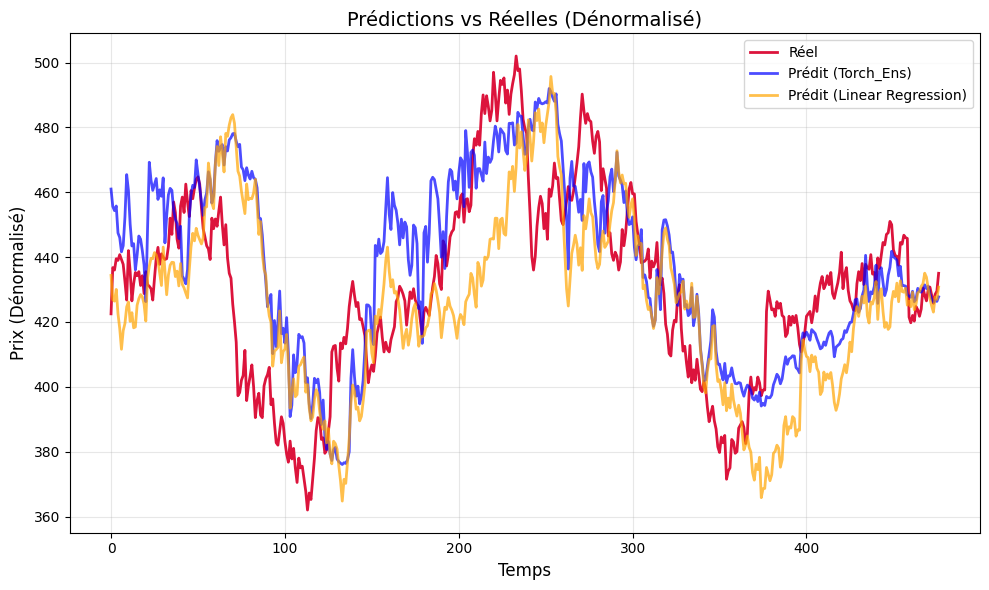

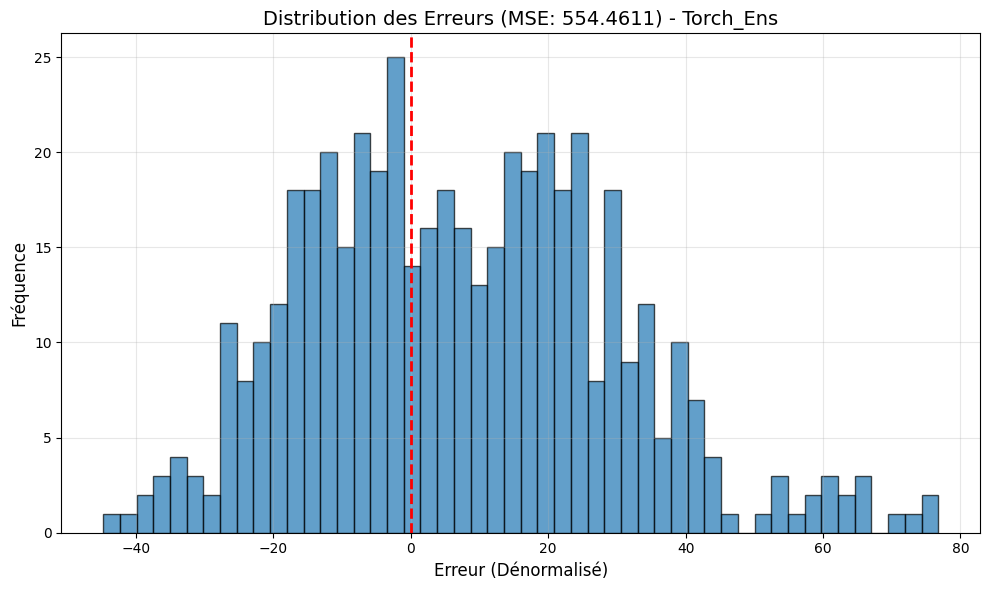

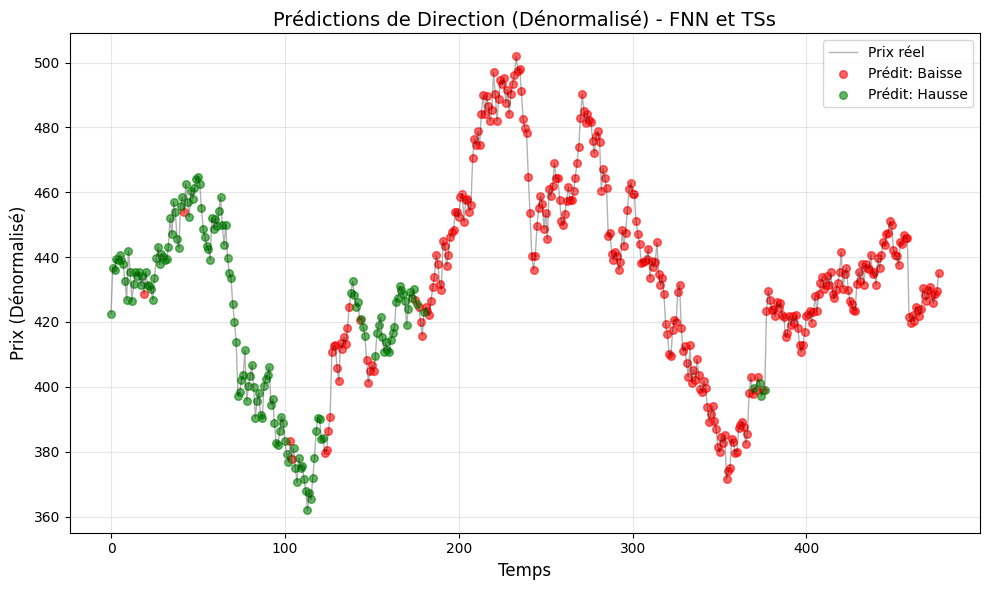

<Figure size 800x800 with 0 Axes>

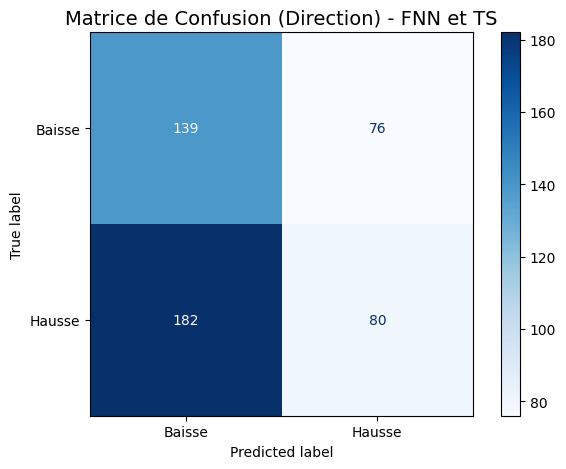


=== Métriques Finales (Dénormalisées) ===

--- Torch_Ens Model ---
MSE: 554.4611
MAE: 18.7931
R-squared: 0.3356
Winrate (Regression Head): 53.36%
Direction Classification Accuracy: 45.91%

--- Scikit-learn Linear Regression Model ---
MSE: 678.5816
MAE: 21.3944
R-squared: 0.1869
Winrate (Regression): 48.53%


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#On sort les pred

all_predictions = predictions_v
all_targets = targets_v
actual_directions = direction_labels_v
all_directions = direction_preds_v

#On repasse en prix
denorm_all_predictions = all_predictions * (val_dataset.target_max - val_dataset.target_min) + val_dataset.target_min
denorm_all_targets = all_targets * (val_dataset.target_max - val_dataset.target_min) + val_dataset.target_min

denorm_predictions_lr = predictions_lr * int(val_dataset.target_max - val_dataset.target_min) + val_dataset.target_min
denorm_y_val_lr = y_val_lr * int(val_dataset.target_max - val_dataset.target_min) + val_dataset.target_min

#Les errors
denorm_all_errors = denorm_all_predictions - denorm_all_targets

# --- Plotting --- Merci Claude

# Plot 1: Predictions vs Actuals (Denormalized) - Torch_Ens and Linear Regression
plt.figure(figsize=(10, 6))
plt.plot(denorm_all_targets, c='crimson', label='Réel', linewidth=2)
plt.plot(denorm_all_predictions, c='blue', label='Prédit (Torch_Ens)', linewidth=2, alpha=0.7)
plt.plot(denorm_predictions_lr, c='orange', label='Prédit (Linear Regression)', linewidth=2, alpha=0.7)
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (Dénormalisé)', fontsize=12)
plt.title("Prédictions vs Réelles (Dénormalisé)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Error distribution (Denormalized) - Torch_Ens
plt.figure(figsize=(10, 6))
mse_denorm_ens = np.mean(denorm_all_errors**2)
plt.hist(denorm_all_errors, bins=50, edgecolor='black', alpha=0.7)
plt.title(f"Distribution des Erreurs (MSE: {mse_denorm_ens:.4f}) - Torch_Ens", fontsize=14)
plt.xlabel('Erreur (Dénormalisé)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Direction predictions (using Denormalized Actuals) - Torch_Ens
plt.figure(figsize=(10, 6))
direction_map = {0: 'Baisse', 1: 'Hausse'}
direction_colors = {0: 'red',1: 'green'}

# Plot the actual prices
plt.plot(denorm_all_targets, c='black', linewidth=1, alpha=0.3, label='Prix réel')

# Plot scatter points for each direction separately to get correct legend entries
for direction_class in sorted(direction_map.keys()):
    mask = (all_directions == direction_class)
    if mask.sum() > 0:
        plt.scatter(np.arange(len(denorm_all_targets))[mask],
                           denorm_all_targets[mask],
                           c=direction_colors[direction_class],
                           alpha=0.6, s=30,
                           label=f'Prédit: {direction_map[direction_class]}')

plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (Dénormalisé)', fontsize=12)
plt.title("Prédictions de Direction (Dénormalisé) - FNN et TSs", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Confusion matrix for direction - Torch_Ens (no change needed as it uses labels)
plt.figure(figsize=(8, 8))
cm = confusion_matrix(actual_directions, all_directions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Baisse', 'Hausse'])
disp.plot(cmap='Blues')
plt.title("Matrice de Confusion (Direction) - FNN et TS", fontsize=14)
plt.tight_layout()
plt.show()

# --- Additional metrics (Denormalized) ---
print("\n=== Métriques Finales (Dénormalisées) ===")

# Metrics for Torch_Ens
print("\n--- Torch_Ens Model ---")
mse_ens_denorm = np.mean(denorm_all_errors**2)
mae_ens_denorm = np.mean(np.abs(denorm_all_errors))
r2_ens_denorm = metrics.r2_score(denorm_all_targets, denorm_all_predictions)
print(f"MSE: {mse_ens_denorm:.4f}")
print(f"MAE: {mae_ens_denorm:.4f}")
print(f"R-squared: {r2_ens_denorm:.4f}")

# Winrate for Regression Head (Torch_Ens)
pred_returns_ens_denorm = (denorm_all_predictions[1:] - denorm_all_predictions[:-1]) / (denorm_all_predictions[:-1] + 1e-8)
actual_returns_ens_denorm = (denorm_all_targets[1:] - denorm_all_targets[:-1]) / (denorm_all_targets[:-1] + 1e-8)
winrate_regression_ens_denorm = ((pred_returns_ens_denorm > 0) == (actual_returns_ens_denorm > 0)).mean() * 100
print(f"Winrate (Regression Head): {winrate_regression_ens_denorm:.2f}%")

# Direction Classification Accuracy (Torch_Ens) - no change as it's label-based
direction_acc = (actual_directions == all_directions).mean() * 100
print(f"Direction Classification Accuracy: {direction_acc:.2f}%")


# Metrics for Scikit-learn Linear Regression
print("\n--- Scikit-learn Linear Regression Model ---")
mse_lr_denorm = metrics.mean_squared_error(denorm_y_val_lr, denorm_predictions_lr)
mae_lr_denorm = np.mean(np.abs(denorm_y_val_lr - denorm_predictions_lr))
r2_lr_denorm = metrics.r2_score(denorm_y_val_lr, denorm_predictions_lr)
print(f"MSE: {mse_lr_denorm:.4f}")
print(f"MAE: {mae_lr_denorm:.4f}")
print(f"R-squared: {r2_lr_denorm:.4f}")

# Winrate for Scikit-learn Linear Regression
pred_returns_lr_denorm = (denorm_predictions_lr[1:] - denorm_predictions_lr[:-1]) / (denorm_predictions_lr[:-1] + 1e-8)
actual_returns_lr_denorm = (denorm_y_val_lr[1:] - denorm_y_val_lr[:-1]) / (denorm_y_val_lr[:-1] + 1e-8)
winrate_regression_lr_denorm = ((pred_returns_lr_denorm > 0) == (actual_returns_lr_denorm > 0)).mean() * 100
print(f"Winrate (Regression): {winrate_regression_lr_denorm:.2f}%")


--- Backtesting Performance Metrics ---

Strategy: Long Only
  Total Log Return: 2.5412
  Number of Trading Days: 457
  Annualized Return: 101.13%

Strategy: Long/Short
  Total Log Return: 4.0379
  Number of Trading Days: 457
  Annualized Return: 144.39%

Strategy: Buy & Hold
  Total Log Return: 0.0558
  Number of Trading Days: 457
  Annualized Return: 3.05%


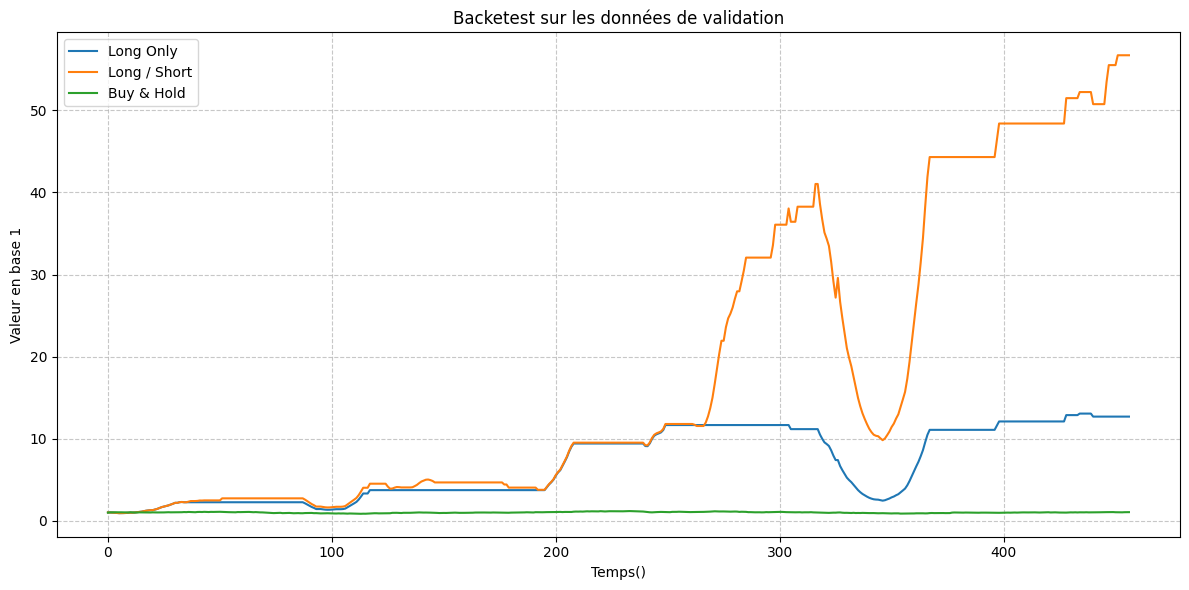

In [30]:
### backtest sur validation

# Create a DataFrame from the validation results
df_backtest = pd.DataFrame({
    "Pt": denorm_all_targets,
    "prediction": denorm_all_predictions,
    "classification": direction_preds_v
})


# Prix futur (shift by 20 days as per dataset logic)
df_backtest["Future_Price"] = df_backtest["Pt"].shift(-20)

df_backtest = df_backtest.dropna()

# Define transaction cost (e.g., 0.1% per trade)
transaction_cost_per_trade = 0.001

# CONDITIONS
long_condition = (
    (df_backtest["classification"] == 1) &
    (df_backtest["prediction"] > df_backtest["Pt"])
)
short_condition = (
    (df_backtest["classification"] == 0) &
    (df_backtest["prediction"] < df_backtest["Pt"])
)

# Rendements
# Long trades (buy when conditions met)
df_backtest["Long_return"] = np.where(
    long_condition,
    np.log(df_backtest["Future_Price"] / df_backtest["Pt"]) - transaction_cost_per_trade,
    0
)

# Short trades (sell when conditions met)
df_backtest["Short_return"] = np.where(
    short_condition,
    np.log(df_backtest["Pt"] / df_backtest["Future_Price"]) - transaction_cost_per_trade,
    0
)

# Long Only Strategy
df_backtest["Strategy_Long_Only"] = df_backtest["Long_return"]

# Long / Short Strategy
df_backtest["Strategy_Long_Short"] = df_backtest["Long_return"] + df_backtest["Short_return"]

# Buy and Hold (Holding the Future) Strategy
df_backtest["Buy_Hold_Return"] = np.log(df_backtest["Pt"] / df_backtest["Pt"].shift(1))
df_backtest["Buy_Hold_Return"] = df_backtest["Buy_Hold_Return"].fillna(0)

# Calculate Equity Curves
df_backtest["Equity_Long_Only"] = np.exp(df_backtest["Strategy_Long_Only"].cumsum())
df_backtest["Equity_Long_Short"] = np.exp(df_backtest["Strategy_Long_Short"].cumsum())
df_backtest["Equity_Buy_Hold"] = np.exp(df_backtest["Buy_Hold_Return"].cumsum())


# Print Summary Statistics
print("\n--- Backtesting Performance Metrics ---")

trading_days_per_year = 252

def calculate_metrics(returns_series, strategy_name):
    total_return = returns_series.sum()
    num_trades = (returns_series != 0).sum()
    avg_return_per_trade = returns_series.sum() / num_trades if num_trades > 0 else 0
    num_trading_periods = len(returns_series[returns_series != 0])

    if strategy_name == "Buy & Hold":
        daily_avg_log_return = returns_series.mean()
        annualized_return = (sum(returns_series)+1)**(252/456) - 1
    else:
        daily_avg_log_return = returns_series.mean() # Average over all periods
        annualized_return =  (sum(returns_series)+1)**(252/456) - 1 # Assuming daily average return

    print(f"\nStrategy: {strategy_name}")
    print(f"  Total Log Return: {total_return:.4f}")
    print(f"  Number of Trading Days: {len(returns_series)}")
    print(f"  Annualized Return: {annualized_return * 100:.2f}%")

calculate_metrics(df_backtest["Strategy_Long_Only"], "Long Only")
calculate_metrics(df_backtest["Strategy_Long_Short"], "Long/Short")
calculate_metrics(df_backtest["Buy_Hold_Return"], "Buy & Hold")


# Graphique
plt.figure(figsize=(12, 6))
plt.plot(df_backtest["Equity_Long_Only"], label="Long Only")
plt.plot(df_backtest["Equity_Long_Short"], label="Long / Short")
plt.plot(df_backtest["Equity_Buy_Hold"], label="Buy & Hold")

plt.title("Backetest sur les données de validation")
plt.xlabel("Temps()")
plt.ylabel("Valeur en base 1")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

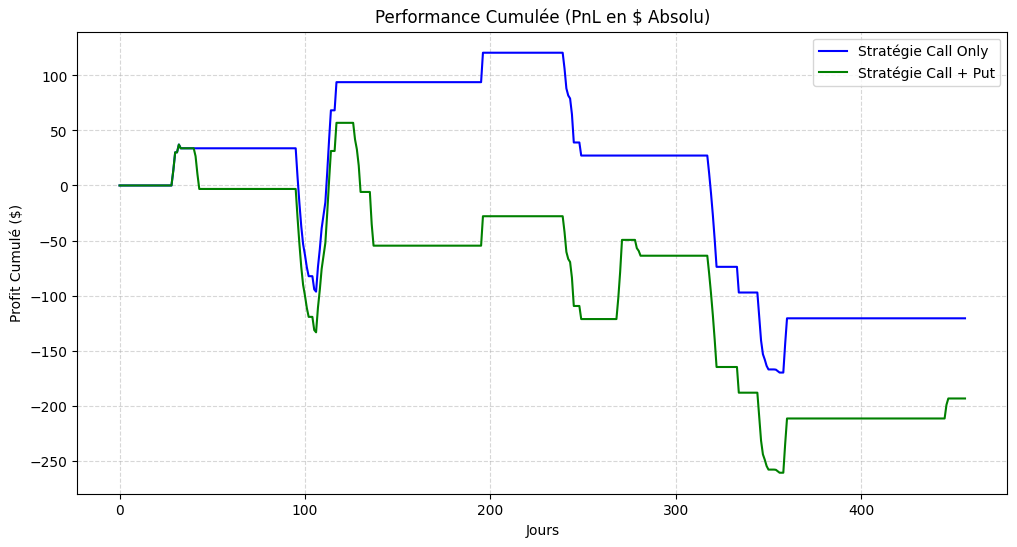

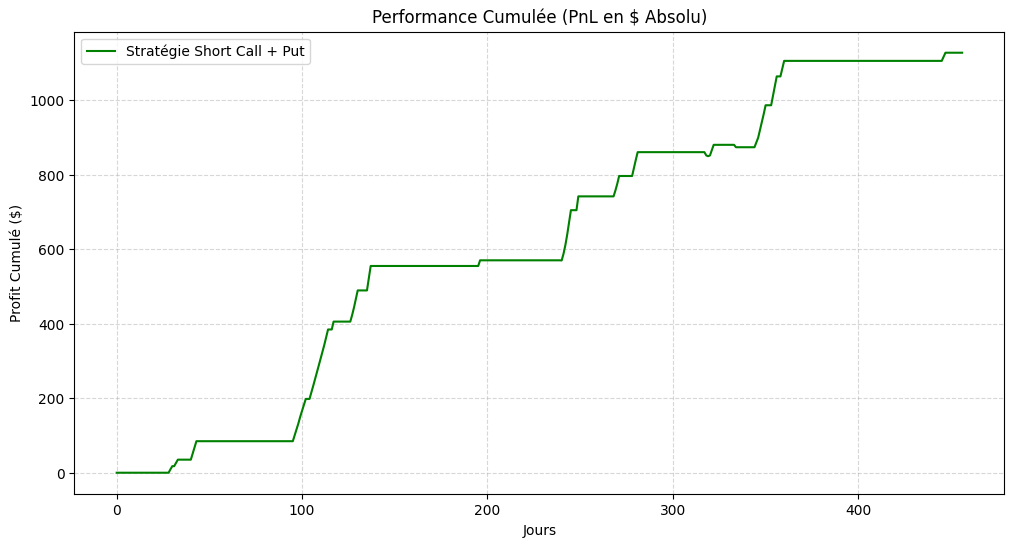

In [35]:
## Backtest Options

df_backtest['Pt_sd'] = df_backtest['Pt'].rolling(window=30).std()
df_backtest['vol'] = df_backtest['Pt_sd']/df_backtest['Pt'] * np.sqrt(365)
rf = 1.03**(20/360)-1
T = 20/360

d1 = (np.log(df_backtest['Pt'] / df_backtest['Pt']) + (rf + 0.5 * df_backtest['vol']**2) * T) / (df_backtest['vol'] * np.sqrt(T))
d2 = d1 - df_backtest['vol'] * np.sqrt(T)

df_backtest['Call_Price'] = (
    df_backtest['Pt'] * norm.cdf(d1) -
    df_backtest['Pt'] * np.exp(-rf * T) * norm.cdf(d2)
)

df_backtest['Put_ATM'] = (
    df_backtest['Pt'] * np.exp(-rf * T) * norm.cdf(-d2) -
    df_backtest['Pt'] * norm.cdf(-d1)
)

# On met en place B&S
# Retour au Long Call Only ou au Long Call / Long Put

# Potentiel de rendement plus fort que breakeven
cond_long_call = (
    (df_backtest['classification'] == 1) &
    (df_backtest['prediction'] > (df_backtest['Pt'] + df_backtest['Call_Price']))
)

cond_long_put = (
    (df_backtest['classification'] == 0) &
    (df_backtest['prediction'] < (df_backtest['Pt'] - df_backtest['Put_ATM']))
)

intrinsic_value_call = np.maximum(df_backtest['Future_Price'] - df_backtest['Pt'], 0)
df_backtest['PnL_Call'] = np.where(
    cond_long_call,
    intrinsic_value_call - df_backtest['Call_Price'],
    0
)

intrinsic_value_put = np.maximum(df_backtest['Pt'] - df_backtest['Future_Price'], 0)
df_backtest['PnL_Put'] = np.where(
    cond_long_put,
    intrinsic_value_put - df_backtest['Put_ATM'],
    0
)

df_backtest['Call_Only'] = df_backtest['PnL_Call'].cumsum()
df_backtest['Call_Put'] = df_backtest['PnL_Call'].cumsum() + df_backtest['PnL_Put'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_backtest['Call_Only'], label='Stratégie Call Only', color='blue')
plt.plot(df_backtest['Call_Put'], label='Stratégie Call + Put', color='green')

plt.title('Performance Cumulée (PnL en $ Absolu)')
plt.xlabel('Jours')
plt.ylabel('Profit Cumulé ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Short d'options

cond_short_put = (df_backtest['classification'] == 1) & (df_backtest['prediction'] > (df_backtest['Pt'] + df_backtest['Put_ATM']))
cond_short_call = (df_backtest['classification'] == 0) & (df_backtest['prediction'] < (df_backtest['Pt'] - df_backtest['Call_Price']))

intrinsic_value_call = np.maximum(df_backtest['Future_Price'] - df_backtest['Pt'], 0)
df_backtest['PnL_SCall'] = np.where(
    cond_short_call,
    df_backtest['Call_Price'] - intrinsic_value_call,
    0
)

intrinsic_value_put = np.maximum(df_backtest['Pt'] - df_backtest['Future_Price'], 0)
df_backtest['PnL_SPut'] = np.where(
    cond_short_put,
    df_backtest['Put_ATM'] - intrinsic_value_put,
    0
)

df_backtest['SCall_SPut'] = df_backtest['PnL_SCall'].cumsum() + df_backtest['PnL_SPut'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_backtest['SCall_SPut'], label='Stratégie Short Call + Put', color='green')

plt.title('Performance Cumulée (PnL en $ Absolu)')
plt.xlabel('Jours')
plt.ylabel('Profit Cumulé ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()